In [2]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE

# Load training and testing datasets
train_data = pd.read_csv('/kaggle/input/customer-churn-dataset/customer_churn_dataset-training-master.csv')
test_data = pd.read_csv('/kaggle/input/customer-churn-dataset/customer_churn_dataset-testing-master.csv')

# Specify the important columns
important_columns = ['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 
                     'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Churn']

# Visualize data before preprocessing
print("Columns before preprocessing:")
print(train_data.columns)

# Preprocessing the data
def preprocess_data(df):
    # Handle duplicate data (remove duplicates)
    df = df.drop_duplicates()

    # Encoding categorical columns
    label_encoders = {}
    categorical_columns = ['Gender', 'Subscription Type', 'Contract Length']
    
    for col in categorical_columns:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])

    # Drop irrelevant/unnecessary columns
    df = df.drop(columns=['CustomerID'])  # Drop CustomerID since it's not useful for prediction

    # Handle missing values
    df = df.fillna(df.median())  # Fill missing values with median values for numeric columns
    
    # Handle outliers (e.g., capping at 99th percentile for numeric columns)
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_columns:
        upper_limit = df[col].quantile(0.99)
        lower_limit = df[col].quantile(0.01)
        df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)
    
    return df

# Preprocess training and testing data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Print columns after preprocessing
print("Columns after preprocessing:")
print(train_data.columns)

# Ensure there are no missing values in the target variable (Churn)
train_data = train_data.dropna(subset=['Churn'])
test_data = test_data.dropna(subset=['Churn'])

# Feature Scaling using MinMaxScaler to ensure non-negative values
scaler = MinMaxScaler()
X_train = train_data.drop(columns=['Churn'])
X_test = test_data.drop(columns=['Churn'])

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Handle class imbalance using SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, train_data['Churn'])

# Print data after SMOTE
print("Data shape after SMOTE (X_train, y_train):", X_train_resampled.shape, y_train_resampled.shape)

# Feature Selection using Chi-Square
chi2_scores, p_values = chi2(X_train_resampled, y_train_resampled)
selected_features = X_train.columns[chi2_scores > 1]  # Select features with chi2 score > 1
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)[selected_features]
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)[selected_features]

# Print columns after feature selection
print("Columns after feature selection:")
print(X_train_resampled.columns)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test_scaled, label=test_data['Churn'])

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'auc',  # AUC-ROC metric
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred_proba = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba]

# Evaluate the model
accuracy = accuracy_score(test_data['Churn'], y_pred)
auc_score = roc_auc_score(test_data['Churn'], y_pred_proba)
classification_rep = classification_report(test_data['Churn'], y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'AUC Score: {auc_score:.4f}')
print('Classification Report:')
print(classification_rep)

# Visualize distributions for important columns (e.g., Age, Tenure)
important_numerical_columns = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Total Spend']


Columns before preprocessing:
Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='object')
Columns after preprocessing:
Index(['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls',
       'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend',
       'Last Interaction', 'Churn'],
      dtype='object')
Data shape after SMOTE (X_train, y_train): (500000, 10) (500000,)
Columns after feature selection:
Index(['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls',
       'Payment Delay', 'Subscription Type', 'Total Spend',
       'Last Interaction'],
      dtype='object')
Accuracy: 0.5176
AUC Score: 0.7587
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.09      0.16     33881
           1       0.50      1.00      0.66     30493

    accura

Columns before preprocessing:
Index(['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls',
       'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend',
       'Last Interaction', 'Churn'],
      dtype='object')


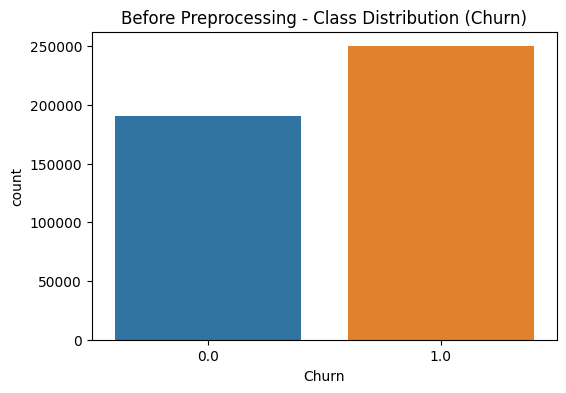

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


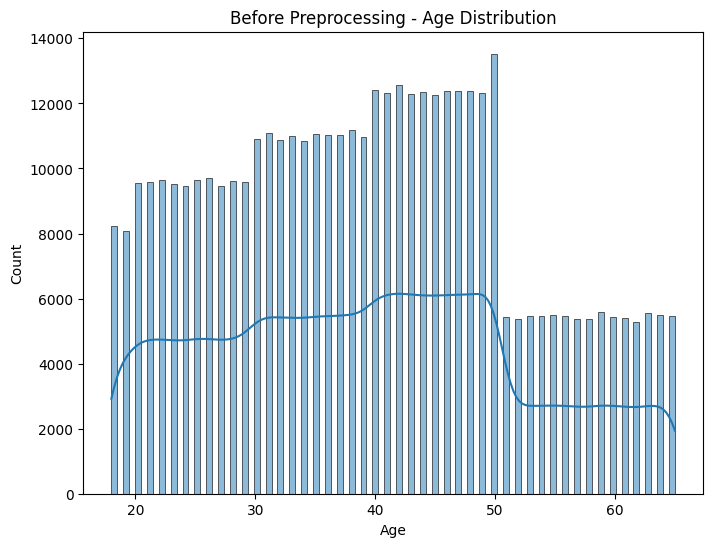

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


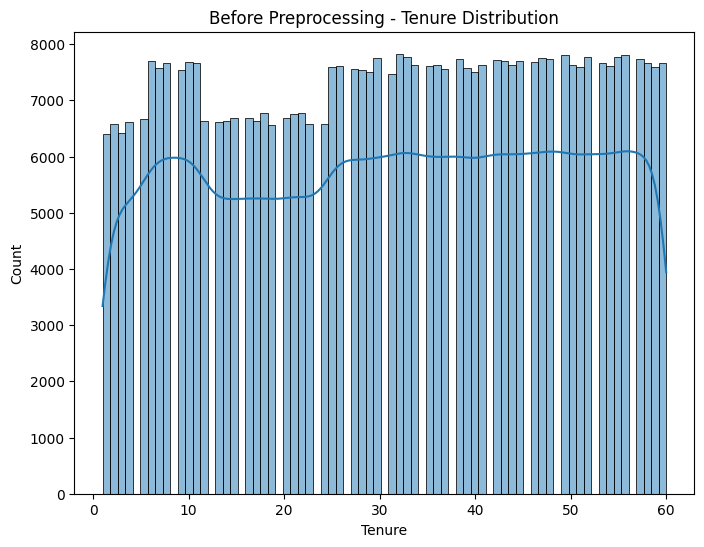

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


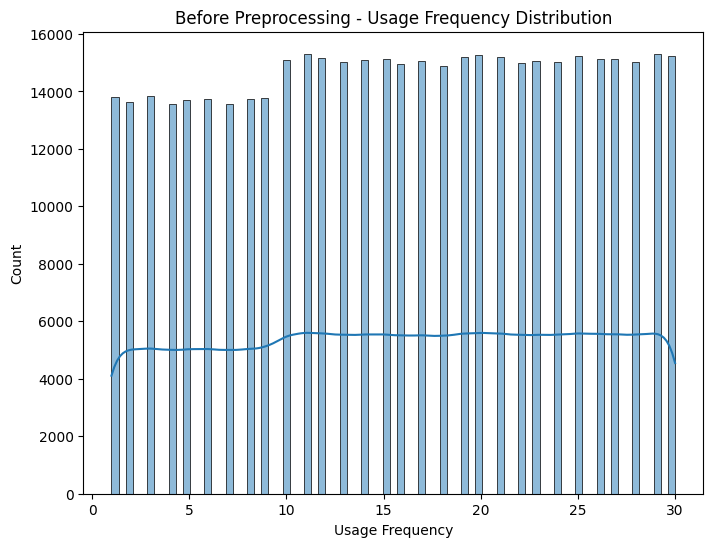

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


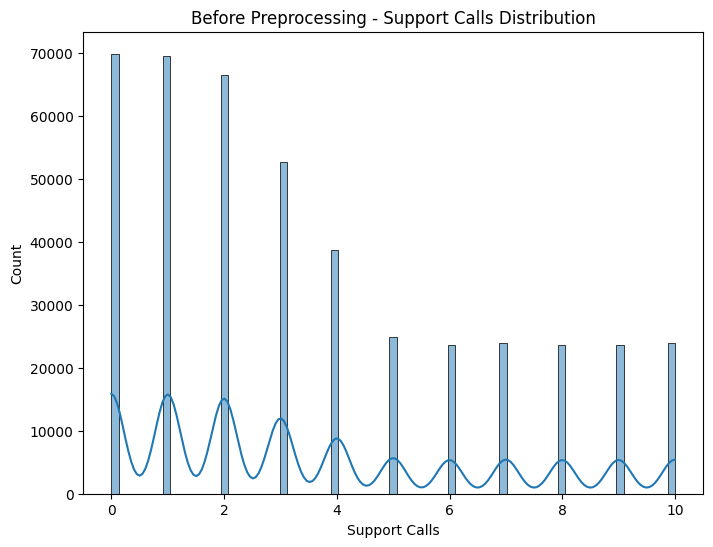

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


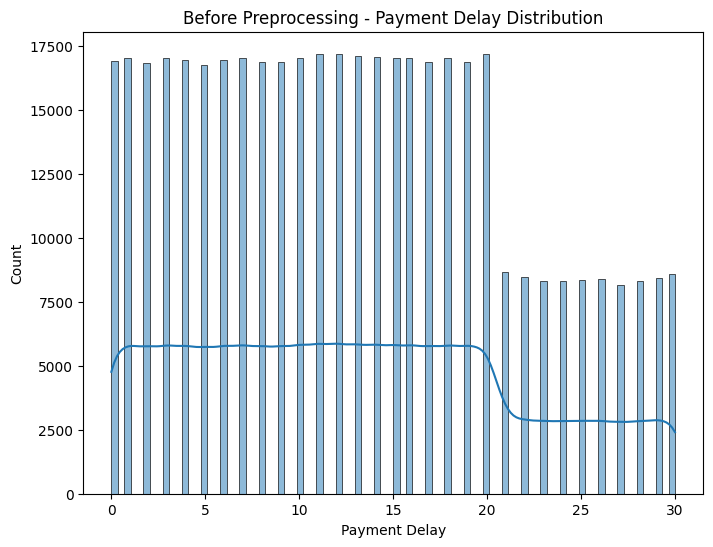

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


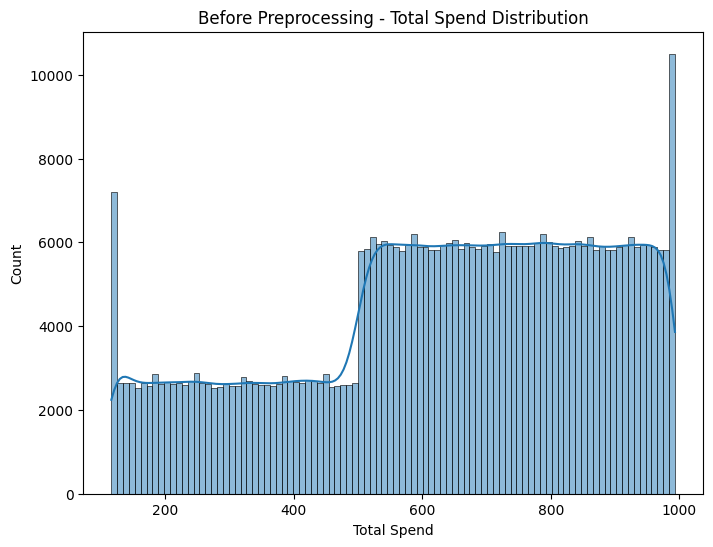

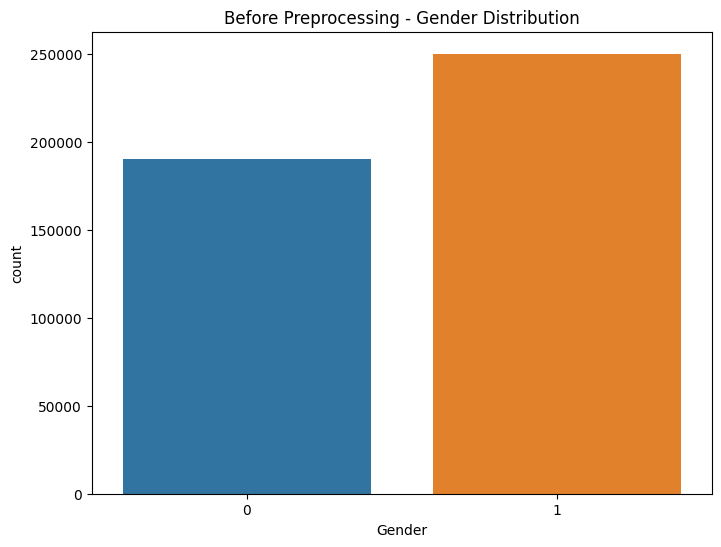

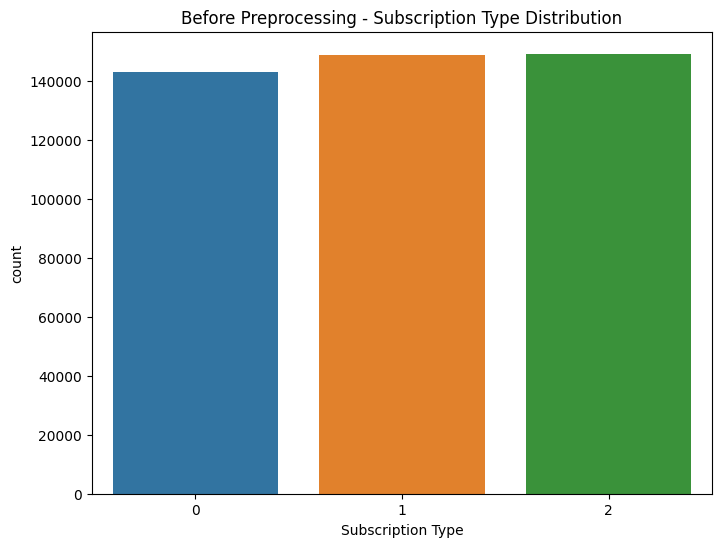

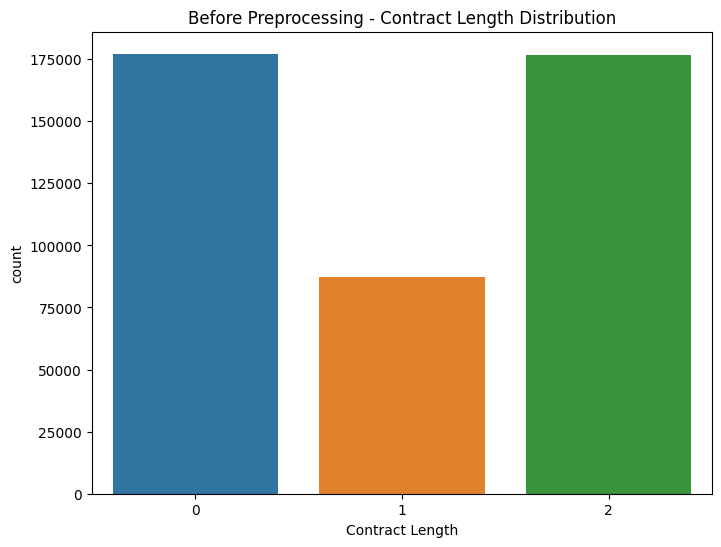

Columns after preprocessing:
Index(['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls',
       'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend',
       'Last Interaction', 'Churn'],
      dtype='object')


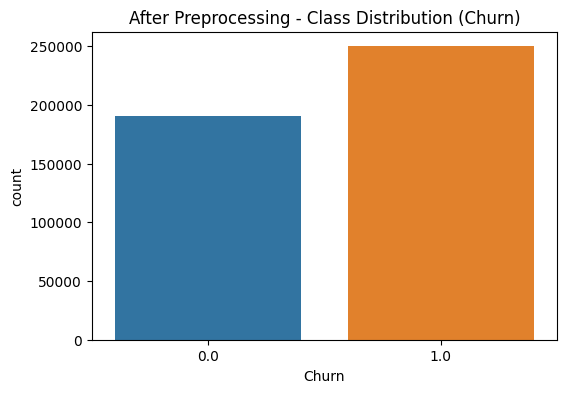

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


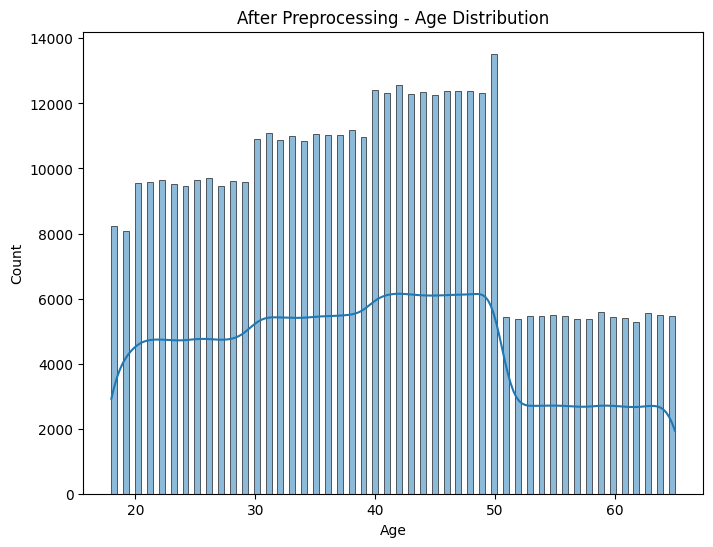

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


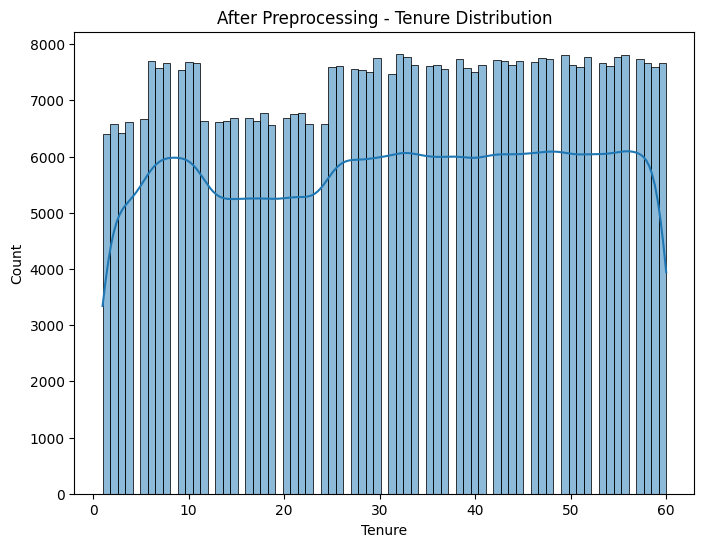

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


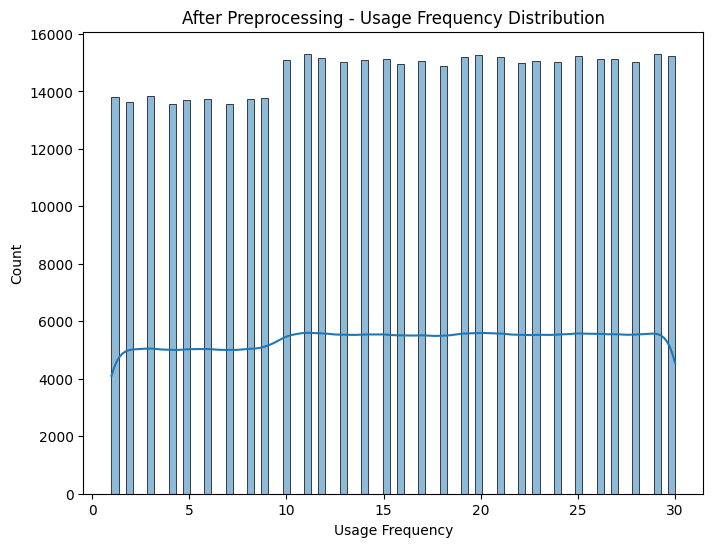

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


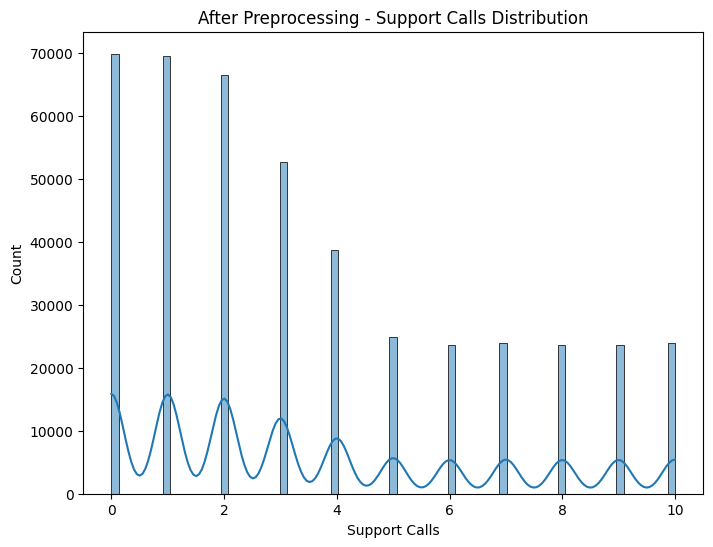

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


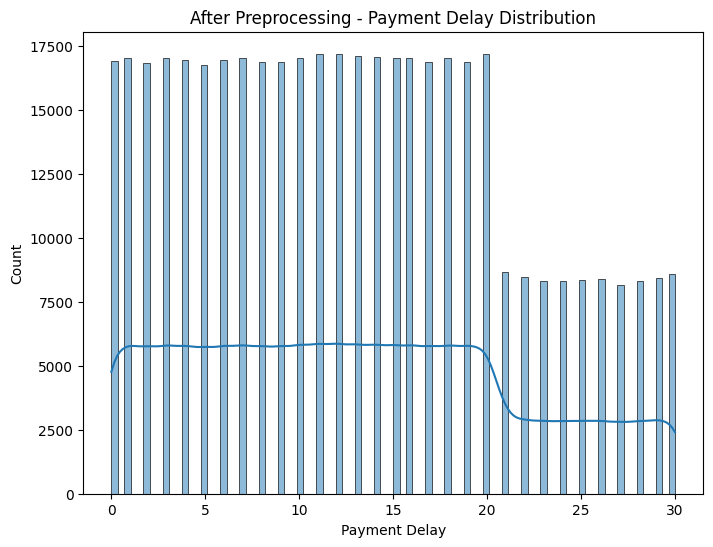

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


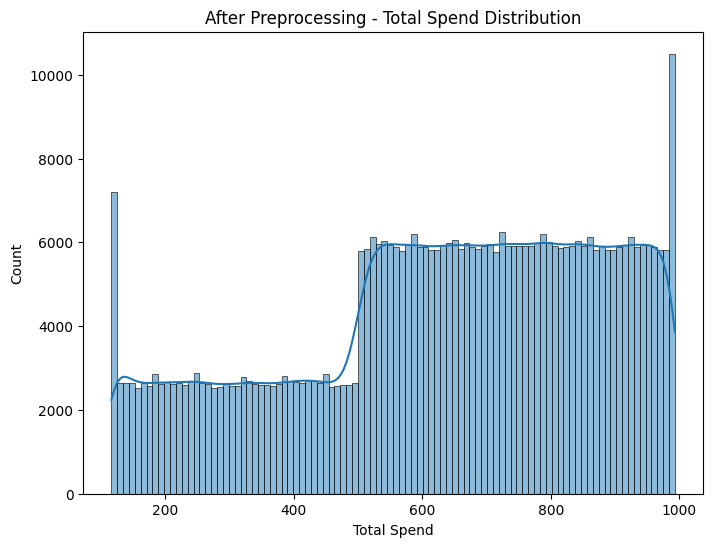

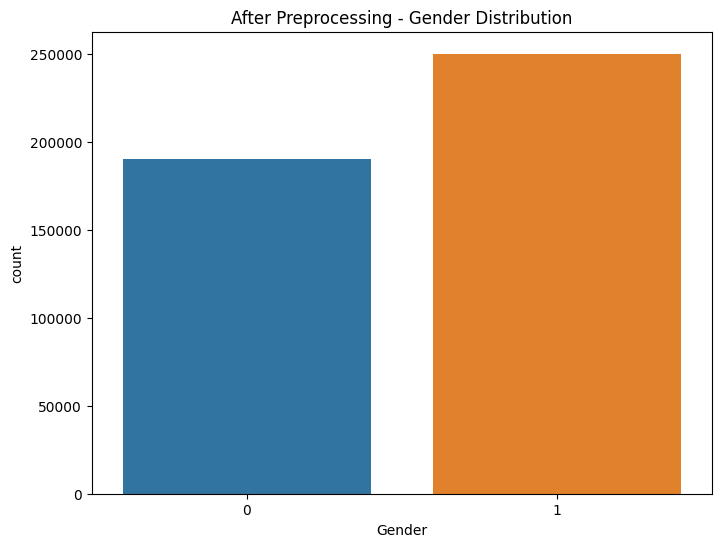

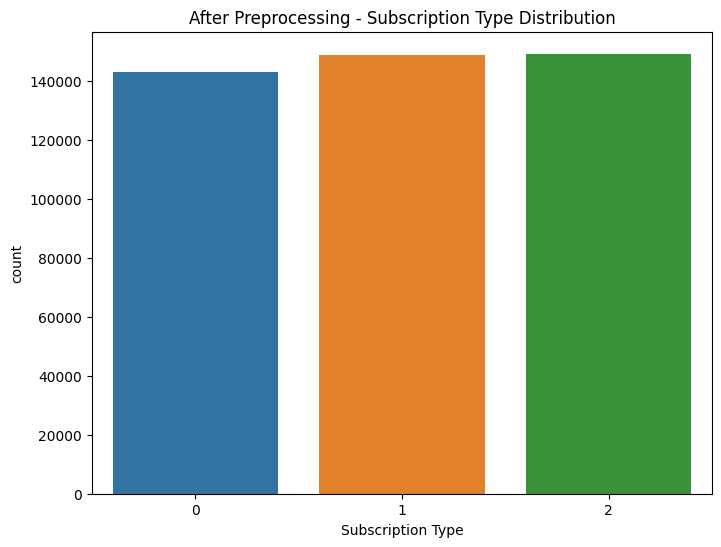

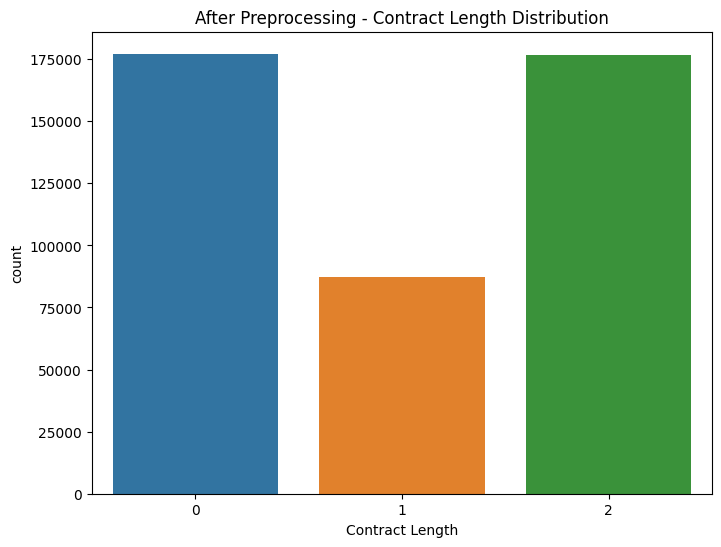

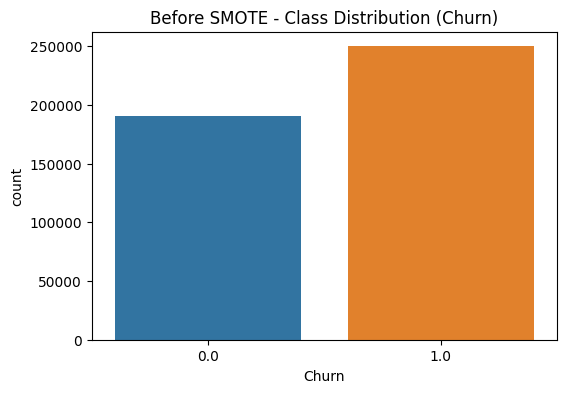

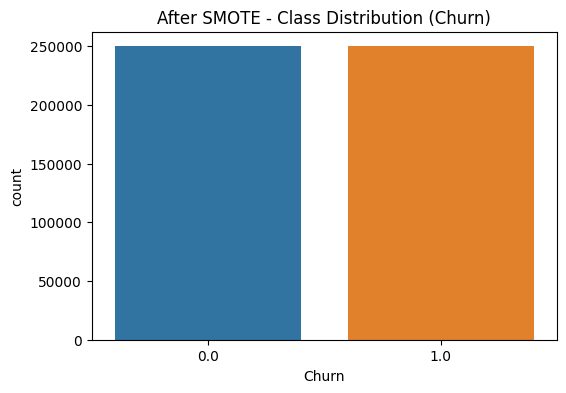

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


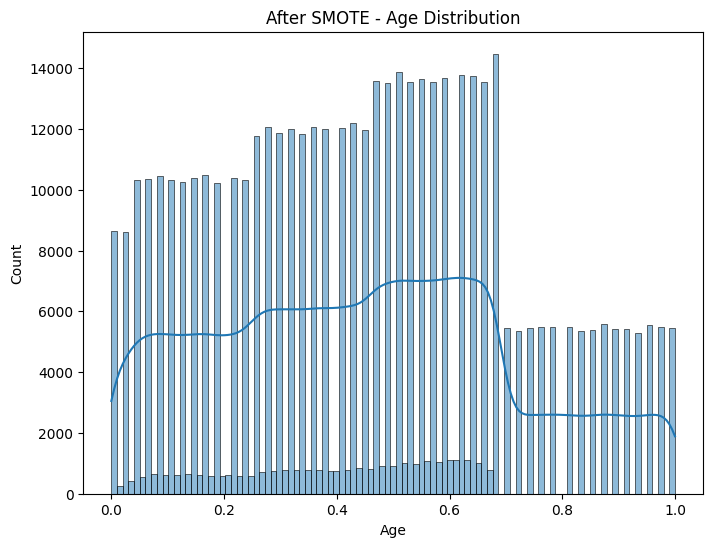

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


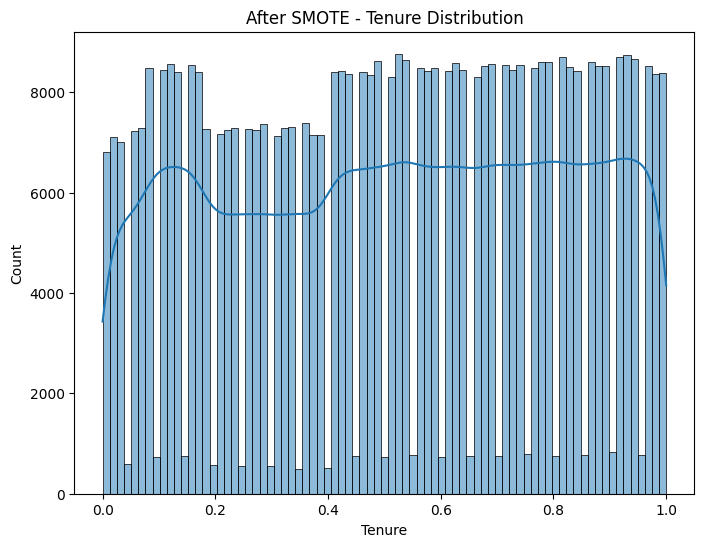

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


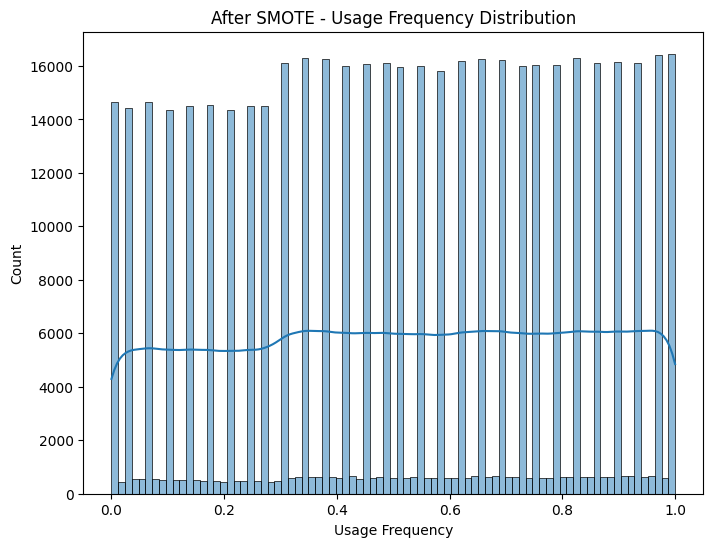

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


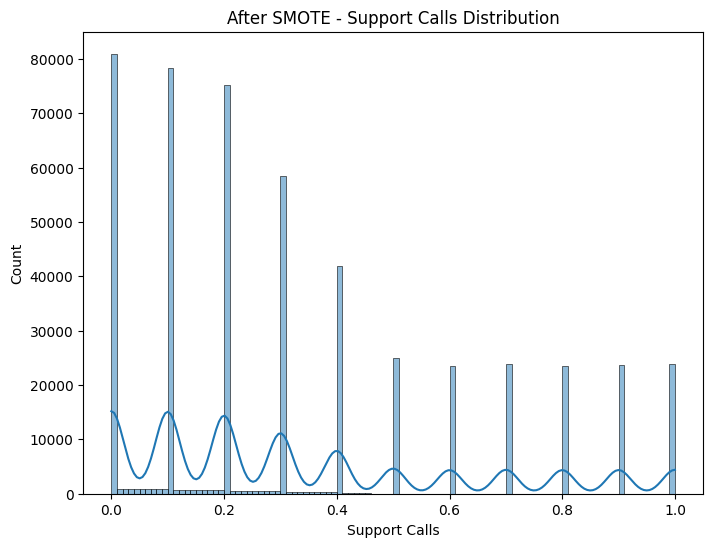

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


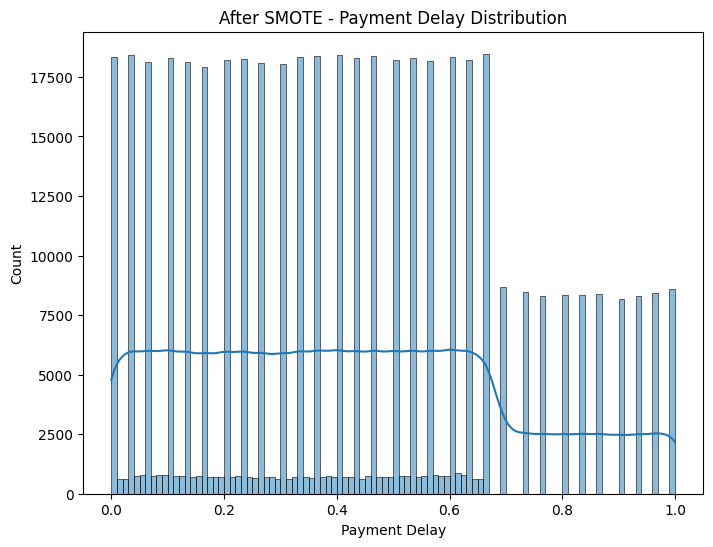

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


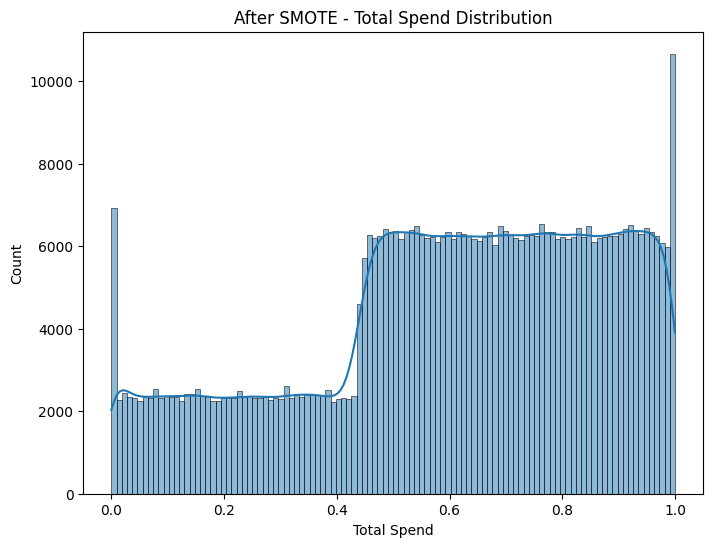

In [3]:
# Visualize Class Distribution (for Churn)
def visualize_class_distribution(y, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y)
    plt.title(f'{title} - Class Distribution (Churn)')
    plt.show()

# Visualize numerical columns (e.g., Age, Tenure, Usage Frequency, etc.)
def visualize_numerical_distribution(df, column, title):
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'{title} - {column} Distribution')
    plt.show()

# Visualize categorical columns (e.g., Gender, Subscription Type)
def visualize_categorical_distribution(df, column, title):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, data=df)
    plt.title(f'{title} - {column} Distribution')
    plt.show()

# Before Preprocessing
print("Columns before preprocessing:")
print(train_data.columns)

# Visualize key columns before preprocessing
visualize_class_distribution(train_data['Churn'], "Before Preprocessing")

for col in ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend']:
    visualize_numerical_distribution(train_data, col, "Before Preprocessing")

for col in ['Gender', 'Subscription Type', 'Contract Length']:
    visualize_categorical_distribution(train_data, col, "Before Preprocessing")

# After Preprocessing
print("Columns after preprocessing:")
print(train_data.columns)

# Visualize key columns after preprocessing
visualize_class_distribution(train_data['Churn'], "After Preprocessing")

for col in ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend']:
    visualize_numerical_distribution(train_data, col, "After Preprocessing")

for col in ['Gender', 'Subscription Type', 'Contract Length']:
    visualize_categorical_distribution(train_data, col, "After Preprocessing")

# Visualize before SMOTE
visualize_class_distribution(train_data['Churn'], "Before SMOTE")

# After SMOTE (assume `y_train_resampled` contains resampled target)
visualize_class_distribution(y_train_resampled, "After SMOTE")

# After SMOTE, visualize resampled numeric features
for col in ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend']:
    visualize_numerical_distribution(pd.DataFrame(X_train_resampled, columns=X_train.columns), col, "After SMOTE")
